In [289]:
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import plotly as py
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from helpers import *
from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import pairwise_tukeyhsd

py.offline.init_notebook_mode(connected=True)

# turn off warning
pd.options.mode.chained_assignment = None

In [290]:
#datapath
DATA_FOLDER = "./data/"
MOVIE_PATH=DATA_FOLDER+"CMU/movie.metadata.tsv"
CHARACTER_PATH = DATA_FOLDER+"CMU/character.metadata.tsv"

MOVIE_IMDB_PATH = DATA_FOLDER+"IMDB/title.basics.tsv"
MOVIE_IMDB_RATING_PATH = DATA_FOLDER+"IMDB/title.ratings.tsv"

In [291]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
movies_original = movies.copy()
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)


imdb_movies = pd.read_table(
    MOVIE_IMDB_PATH,
    sep="\t",
    usecols=["tconst", "originalTitle", "startYear", "runtimeMinutes"],
)
imdb_ratings = pd.read_table(MOVIE_IMDB_RATING_PATH, sep="\t")

In [292]:
#imbd movies already has the release date
#add release date to movies
movies["year_released"] = pd.to_datetime(
    movies["movie_release_date"], infer_datetime_format=True, errors="coerce"
).dt.year
#drop the rows with no release date in movies
movies = movies[~movies["year_released"].isna()]

#rename columns to match between movies and imdb_movies
imdb_movies = imdb_movies.rename(
    columns={
        "startYear": "year_released",
        "originalTitle": "movie_name",
        "runtimeMinutes": "movie_runtime",
    }
)

# converting '\\N' values to np.nan
imdb_movies.loc[imdb_movies["year_released"] == "\\N", "year_released"] = np.nan
imdb_movies.loc[imdb_movies["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

# removing all rows containing np.nan
imdb_movies = imdb_movies[imdb_movies["year_released"].notna()]

# converting year released to 'int64'
movies["year_released"] = movies["year_released"].astype("int64")
imdb_movies["year_released"] = imdb_movies["year_released"].astype("int64")

# converting runtime to 'float64'
imdb_movies["movie_runtime"] = imdb_movies["movie_runtime"].astype(
    "float64", errors="ignore"
)

# removing rows with duplicate of ('movie_name', 'release_year', 'movie_runtime') in movies
movies = movies.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
imdb_movies = imdb_movies.drop_duplicates(
    subset=["movie_name", "year_released", "movie_runtime"]
)


/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_49051/3628268272.py:3: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [293]:
#merge 'imdb_movies' with 'imdb_ratings':
imdb_movies = pd.merge(left=imdb_movies, right=imdb_ratings, on="tconst")

# merge 'movies' with 'imdb_movies' + 'imdb_ratings'
movies = pd.merge(
    left=movies,
    right=imdb_movies,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)


In [294]:
movies.head()

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,NaN,NaN,NaN


In [295]:
movies.count()

wikipedia_movie_ID          39362
freebase_movie_ID           39362
movie_name                  39362
movie_release_date          39362
movie_box_office_revenue     6791
movie_runtime               32661
movie_languages             39362
movie_countries             39362
movie_genres                39362
year_released               39362
tconst                      14369
averageRating               14369
numVotes                    14369
dtype: int64

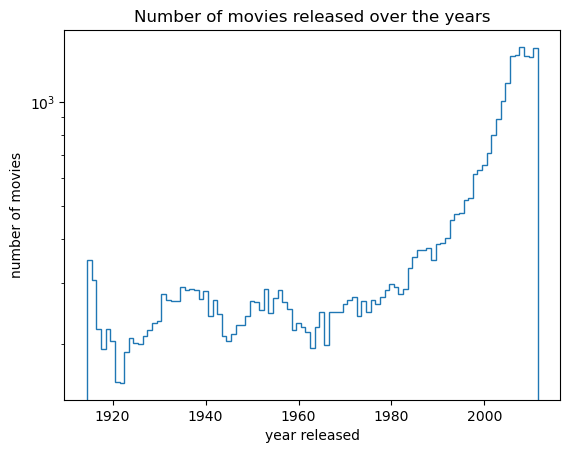

In [296]:
# plot the distribution of release years
bins = np.arange(1915, 2013) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["year_released"], histtype="step", bins=bins, log=True)
plt.title("Number of movies released over the years")
plt.xlabel("year released")
plt.ylabel("number of movies")
plt.show()

(939,)
 "/m/07s9rl0": "Drama"                     9184
 "/m/01z4y": "Comedy"                      4958
{"/m/01jfsb": "Thriller"                   3893
{"/m/02hmvc": "Short Film"                 3573
 "/m/07s9rl0": "Drama"}                    3359
                                           ... 
 "/m/0c031k6": "Live action"                  1
{"/m/07y0lv": "Science fiction Western"       1
 "/m/0bxdv5": "Race movie"                    1
{"/m/05bdtfl": "Period Horror"                1
{"/m/02wtdps": "Crime Thriller"}              1
Name: count, Length: 939, dtype: int64


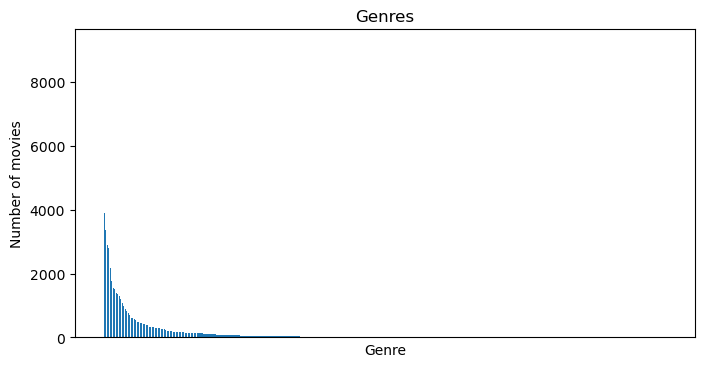

In [297]:
#genres
genres = movies["movie_genres"].str.split(",", expand=True).stack().value_counts()
print(genres.shape)
print(genres)
#plot genres
plt.figure(figsize=(8, 4))
plt.bar(genres.index, genres.values)
#hide x labels
plt.xticks([])
#plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [298]:
#extract the main genre
def extract_genres(row):
    try:
        genres_dict = json.loads(row)
        return list(genres_dict.values()) if genres_dict else ['NaN']
    except json.JSONDecodeError:
        return ['NaN']

# Apply the function to create a new 'genre' column
movies['genre'] = movies['movie_genres'].apply(extract_genres)
genre=movies['genre'].explode().copy()
genre=genre[genre!='NaN']
genre=genre.value_counts()
#find the unique genres
unique_genres = genre.index
print(unique_genres)


Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Short Film', 'Indie', 'Crime Fiction', 'Silent film',
       ...
       'Breakdance', 'Buddy Picture', 'Psychological horror', 'Chick flick',
       'C-Movie', 'Camp', 'Clay animation', 'Hardcore pornography', 'Z movie',
       'Race movie'],
      dtype='object', name='genre', length=348)


In [299]:
# give the top 30 genres that has the largerst number of movies and store them in genre_main
genre_main = genre[:10]
print(genre_main.shape)
print(genre_main.index)

(10,)
Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Short Film', 'Indie', 'Crime Fiction', 'Silent film'],
      dtype='object', name='genre')


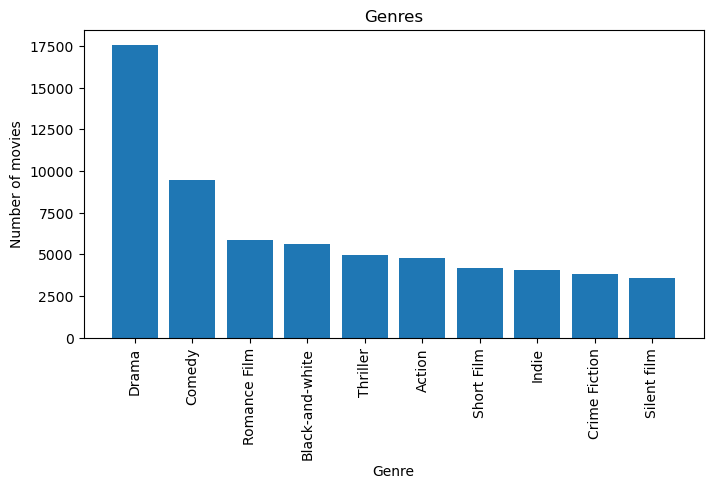

In [300]:
#plot the top 10 genres
plt.figure(figsize=(8, 4))
plt.bar(genre_main.index, genre_main.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [301]:
#filter the movies that have the genres in genre_main, not necessarily the first genre
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
print(movies_main.shape)
movies_main.head()


(32752, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]"
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0,"[Short Film, Silent film, Indie, Black-and-whi..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0,"[Musical, Comedy, Black-and-white]"
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,NaN,NaN,NaN,"[Romantic comedy, Ensemble Film, Comedy-drama,..."


(10,)
Index(['Drama', 'Comedy', 'Romance Film', 'Black-and-white', 'Thriller',
       'Action', 'Short Film', 'Indie', 'Crime Fiction', 'Silent film'],
      dtype='object', name='genre')


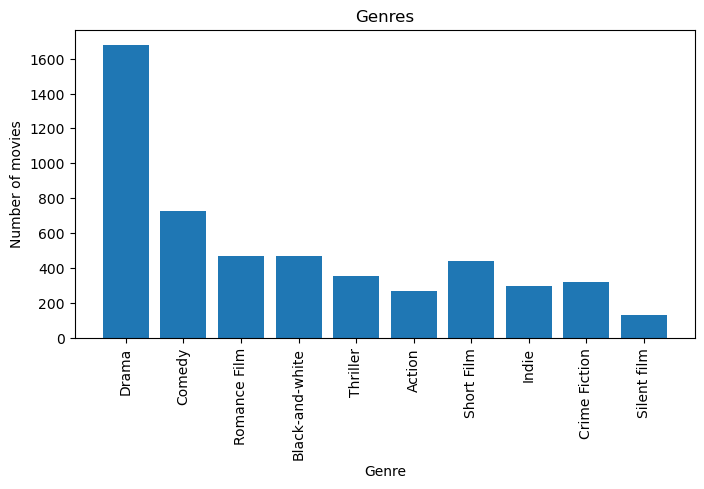

In [302]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
#for each genre in genre_main, find the number of movies in movies_main_filter that have the genre
#and plot the number of movies for each genre
genre_main_filtered = movies_main_filtered['genre'].explode().value_counts()[genre_main.index]
print(genre_main_filtered.shape)
print(genre_main_filtered.index)
plt.figure(figsize=(8, 4))
plt.bar(genre_main_filtered.index, genre_main_filtered.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

From the graph we could see that Drama has more high rating movies, but this is mostly due to the large base number of genre movies.
Therefore we will further consider the ratio between the number of high rating movies and the number of total movies with the same genre, which we define as success_rate.

(10, 2)


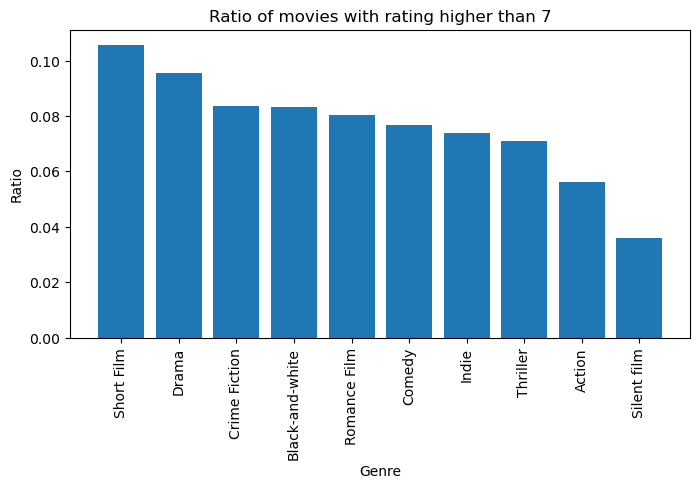

In [303]:
#for each genre, calculate the ratio of movies with rating higher than 7 / total number of movies in that genre
genre_ratio = pd.DataFrame(columns=['genre', 'ratio'])
for g in genre_main.index:
    ratio = len(movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]) / len(movies_main[movies_main['genre'].apply(lambda x: g in x)])
    #add the genre and ratio to the dataframe
    genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio
genre_ratio = genre_ratio.sort_values(by='ratio', ascending=False)
print(genre_ratio.shape)
#plot the ratio
plt.figure(figsize=(8, 4))
plt.bar(genre_ratio['genre'], genre_ratio['ratio'])
plt.xticks(rotation=90)
plt.title("Ratio of movies with rating higher than 7")
plt.xlabel("Genre")
plt.ylabel("Ratio")
plt.show()


In [304]:
# # plot the number of movies for Drama genre for each decade
# # extract the decade from the year_released
# movies_main_filtered['decade'] = movies_main_filtered['year_released'].apply(lambda x: int(x/10)*10)
# #convert the entries of movies_main_filtered['decade'] to int
# movies_main_filtered['decade'] = movies_main_filtered['decade'].astype(int)
# #convert the entries of movies_main_filtered['genre'] to string
# movies_main_filtered['genre'] = movies_main_filtered['genre'].astype(str)
# #group by decade and genre
# movies_main_filtered_decade = movies_main_filtered.groupby(['decade']).reset_index(name='decade')
# print(movies_main_filtered_decade)
# #filter the movies with Drama genre
# movies_main_filtered_decade_drama = movies_main_filtered_decade[movies_main_filtered_decade['genre']=='Drama'].copy()
# #convert the entries of movies_main_filtered_decade_drama['genre'] to string
# movies_main_filtered_decade_drama['genre'] = movies_main_filtered_decade_drama['genre'].astype(str)
# #convert the entries of movies_main_filtered_decade_drama['decade'] to int
# movies_main_filtered_decade_drama['decade'] = movies_main_filtered_decade_drama['decade'].astype(int)
# print(movies_main_filtered_decade_drama)
# #plot the number of movies for Drama genre for each decade
# plt.figure(figsize=(8, 4))
# plt.bar(movies_main_filtered_decade_drama['decade'], movies_main_filtered_decade_drama['count'])
# plt.xticks(rotation=90)
# plt.title("Number of movies with Drama genre for each decade")
# plt.xlabel("Decade")
# plt.ylabel("Number of movies")
# plt.show()


In [305]:
#create a new dataframe with only the top 10 genres and has a rating larger than 7
movies_main = movies[movies["averageRating"] >= 7].copy()
movies_main = movies_main.drop(columns=["movie_genres", "genre"])
movies_main = movies_main.reset_index(drop=True)
print(movies_main.shape)
movies_main.head()


(3247, 12)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,year_released,tconst,averageRating,numVotes
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",1989,tt0097499,7.5,31208.0
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",1964,tt0058331,7.8,181829.0
2,24399617,/m/07s63_7,Bruce Lee: The Lost Interview,1994-11-02,NaN,30.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}",1994,tt0432762,8.6,123.0
3,8669450,/m/027d9tv,One Six Right,2005-11-25,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2005,tt0475994,7.9,457.0
4,164388,/m/015wmt,The Great Santini,1979-10-26,4702575.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",1979,tt0079239,7.2,6812.0


In [306]:
#duration
#the distribution of runtime and its correlation with rating
print(movies[["movie_runtime", "averageRating"]].count())
duration = movies[["movie_runtime", "averageRating"]].dropna()
duration.count()

movie_runtime    32661
averageRating    14369
dtype: int64


movie_runtime    13609
averageRating    13609
dtype: int64

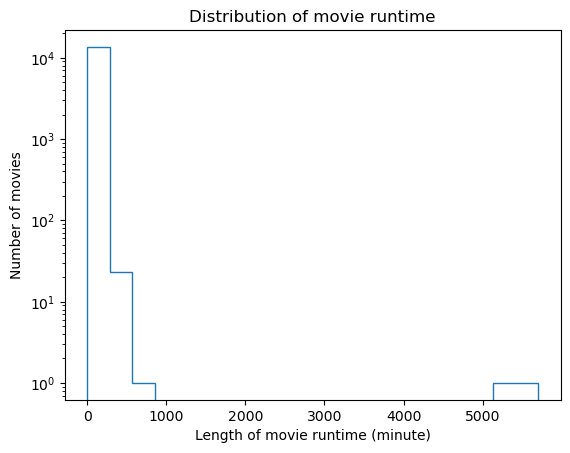

In [307]:
# histogram plot without removing outliers
plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


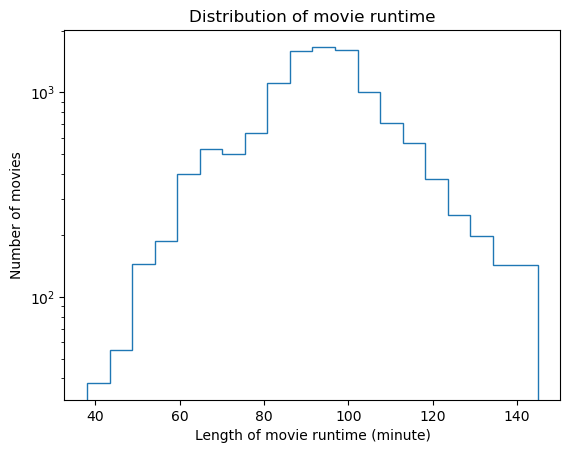

In [308]:
# histogram plot with removing outliers using IQR
q1 = duration["movie_runtime"].quantile(0.25)
q3 = duration["movie_runtime"].quantile(0.75)
iqr = q3 - q1
duration = duration[duration["movie_runtime"] < q3 + 1.5 * iqr]
duration = duration[duration["movie_runtime"] > q1 - 1.5 * iqr]

plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()
